# PII Detection Experiments with Hugging Face Dataset

This notebook explores the [ai4privacy/pii-masking-200k](https://huggingface.co/datasets/ai4privacy/pii-masking-200k) dataset and tests OpenAI's ability to detect PII.

## Setup and Imports

In [3]:
# Install required packages if needed
# !pip install datasets openai python-dotenv

In [3]:
import os
import random
from pathlib import Path
from datasets import load_dataset
from openai import OpenAI
import json
from dotenv import load_dotenv

# Load environment variables from .env file in parent directory (project root)
env_file = Path(__file__).parent.parent / '.env' if '__file__' in globals() else Path.cwd().parent / '.env'

print(f"Looking for .env file at: {env_file}")
if env_file.exists():
    print(f"✓ Found .env file")
    load_dotenv(dotenv_path=env_file)
else:
    print(f"⚠️  .env file not found at {env_file}")
    print("   Will try loading from default locations")
    load_dotenv()

Looking for .env file at: /Users/kodlan/workspaces/python/pii-llm/.env
✓ Found .env file


## Load the Dataset

Loading the PII masking dataset from Hugging Face.

In [4]:
print("Loading dataset...")

# Get Hugging Face token from environment for faster downloads (optional)
hf_token = os.getenv("HF_TOKEN")

if hf_token:
    # Check if it's a placeholder value
    if hf_token.startswith("your-") or "placeholder" in hf_token.lower() or "example" in hf_token.lower():
        print("⚠️  HF_TOKEN appears to be a placeholder value - will use unauthenticated access")
        print("   Edit your .env file and add your actual Hugging Face token for faster downloads")
        hf_token = None
    else:
        print("✓ Using HF_TOKEN for authenticated access (faster downloads)")
else:
    print("⚠️  No HF_TOKEN found - using unauthenticated access (slower)")
    print("   Get a token at https://huggingface.co/settings/tokens to speed up downloads")

# Load dataset with token if available
dataset = load_dataset("ai4privacy/pii-masking-200k", token=hf_token if hf_token else None)
train_data = dataset["train"]

print(f"\nDataset loaded successfully!")
print(f"Total number of samples: {len(train_data)}")
print(f"\nColumn names: {train_data.column_names}")

Loading dataset...
✓ Using HF_TOKEN for authenticated access (faster downloads)

Dataset loaded successfully!
Total number of samples: 209261

Column names: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set']


## Sample Random Entries

Filtering the dataset to English samples only, then selecting 5 random samples with a fixed seed for reproducibility.

In [56]:
# Set number of samples
number_samples = 20
number_prompt_samples = 1000

# Filter dataset to English only
print("Filtering dataset to English samples only...")
english_data = train_data.filter(lambda x: x['language'] == 'en')
print(f"English samples: {len(english_data)} out of {len(train_data)} total")


def get_samples_from_index(data, start_index, num_samples):
    """
    Get samples from the dataset starting at a specific index.
    
    Args:
        data: The dataset to sample from
        start_index: Starting index in the dataset
        num_samples: Number of samples to retrieve
        
    Returns:
        list: List of samples
    """
    samples = [data[i] for i in range(start_index, start_index + num_samples)]
    
    # Verify all samples are English
    languages = [s['language'] for s in samples]
    assert all(lang == 'en' for lang in languages), "Not all samples are English!"
    
    return samples


# Get prompt_samples from the beginning of the dataset
prompt_samples = get_samples_from_index(english_data, start_index=0, num_samples=number_prompt_samples)
print(f"\nSuccessfully sampled {len(prompt_samples)} English entries for prompt_samples (indices 0-{number_prompt_samples-1})")

# Get the main samples from later in the dataset
samples_start_index = 10000
samples = get_samples_from_index(english_data, start_index=samples_start_index, num_samples=number_samples)
print(f"Successfully sampled {len(samples)} English entries for samples (indices {samples_start_index}-{samples_start_index + number_samples - 1})")

Filtering dataset to English samples only...
English samples: 43501 out of 209261 total

Successfully sampled 1000 English entries for prompt_samples (indices 0-999)
Successfully sampled 20 English entries for samples (indices 10000-10019)


## Examine the Samples

Let's look at each sample to understand the data structure.

In [58]:
for i in range(5):
    sample = samples[i]
    print(f"\n{'='*80}")
    print(f"SAMPLE {i} (ID: {sample['id']}, Language: {sample['language']})")
    print(f"{'='*80}")
    
    print(f"\n📄 SOURCE TEXT (with PII):")
    print(f"{sample['source_text']}")
    
    print(f"\n🔒 TARGET TEXT (masked):")
    print(f"{sample['target_text']}")
    
    print(f"\n🏷️  GROUND TRUTH PII:")
    for pii_item in sample['privacy_mask']:
        print(f"  - {pii_item['label']:20s} : '{pii_item['value']}' (pos {pii_item['start']}-{pii_item['end']})")


SAMPLE 0 (ID: 175761, Language: en)

📄 SOURCE TEXT (with PII):
To settle the charges of Pakistan Rupee746,208.95 for your 9 Non-binary child's counseling sessions, kindly use the attached american_express 5943919109159496.

🔒 TARGET TEXT (masked):
To settle the charges of [CURRENCY][AMOUNT] for your [AGE] [GENDER] child's counseling sessions, kindly use the attached [CREDITCARDISSUER] [CREDITCARDNUMBER].

🏷️  GROUND TRUTH PII:
  - CURRENCY             : 'Pakistan Rupee' (pos 25-39)
  - AMOUNT               : '746,208.95' (pos 39-49)
  - AGE                  : '9' (pos 59-60)
  - GENDER               : 'Non-binary' (pos 61-71)
  - CREDITCARDISSUER     : 'american_express' (pos 125-141)
  - CREDITCARDNUMBER     : '5943919109159496' (pos 142-158)

SAMPLE 1 (ID: 175762, Language: en)

📄 SOURCE TEXT (with PII):
Bobby_Wisozk has noted violations of Port Muriel's zoning laws for commercial property on Toy Landing. A cease and desist order expected.

🔒 TARGET TEXT (masked):
[USERNAME] has not

## Setup OpenAI API

Configure the OpenAI client using the API key from environment variables.

In [59]:
# Get API key from environment variable
api_key = os.getenv("OPENAI_API_KEY")

# Validate API key
if not api_key:
    raise ValueError("OPENAI_API_KEY not found in environment variables.\n\n")

# Check if it's still the placeholder value from .env.example
if api_key.startswith("your-") or "placeholder" in api_key.lower() or "example" in api_key.lower():
    raise ValueError("OPENAI_API_KEY appears to be the placeholder value from .env.example.\n\n")

# Initialize OpenAI client
client = OpenAI(api_key=api_key)
print("✓ OpenAI client initialized successfully")

✓ OpenAI client initialized successfully


## Send Samples to OpenAI for PII Detection

Process each sample and get PII detection results from OpenAI.

In [60]:
from collections.abc import Callable

def detect_pii_with_model(sample, model_name, client, get_prompt: Callable[[str], str]):
    """
    Detect PII in a sample using a specific OpenAI model.
    
    Args:
        sample: Dataset sample containing 'source_text'
        model_name: OpenAI model name (e.g., 'gpt-4o-mini', 'gpt-5.2')
        client: OpenAI client instance
        get_prompt: function that generates prompt
    Returns:
        dict: Result containing detected PII or error information
    """

    prompt = get_prompt(sample['source_text'])

    result = {
            "sample_id": sample['id'],
            "source_text": sample['source_text'],
            "ground_truth": sample['privacy_mask'],
            "model": model_name
    }

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a PII detection expert. Return only valid JSON."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,  # deterministic output
            response_format={"type": "json_object"}
        )
        
        # Extract the response
        llm_response = response.choices[0].message.content
        
        detected_pii = json.loads(llm_response)

        result["detected_pii"] = detected_pii
        result["raw_response"] = llm_response

        return result
        
    except json.JSONDecodeError as e:
        result["error"] = "Invalid JSON response"
        return result
    except Exception as e:
        result["error"] = str(e)
        return result


## Send Samples to OpenAI for PII Detection

Process each sample and get PII detection results from two OpenAI models:
- **gpt-4o-mini**: Cost-effective baseline model
- **gpt-5.2**: Latest and most capable model (as of Jan 2026)

In [61]:
models_to_test = [
    "gpt-4o-mini",  # Cost-effective baseline
    "gpt-5.2"       # Latest flagship model
]

def print_result(result):
    if 'error' in result:
        print(f"   ❌ Error: {result['error']}")
        print(f"   ✓ Raw Response: {result['raw_response'].strip().replace('\n', '')}")
    else:
        print(f"   ✓ Response: {", ".join(result["detected_pii"]["pii"])}")

def print_sample_data(sample):
    # Show sample text
    print(f"\n📄 Text: {sample['source_text']}")

    # Show expected PII (ground truth)
    print(f"\n🏷️  Expected PII ({len(sample['privacy_mask'])} items):")
    for pii_item in sample['privacy_mask']:
        print(f"   • {pii_item['label']:20s} : '{pii_item['value']}'")

def print_header(sample):
    print(f"\n{'='*80}")
    print(f"Processing Sample {i} (ID: {sample['id']})")
    print(f"{'='*80}")

def test_prompt_with_models(samples, get_prompt: Callable[[str], str]):
    results_for_prompt_per_model: dict[str, list[object]] = {}
    for i, sample in enumerate(samples):
        # Test with each model
        for model_name in models_to_test:
            result = detect_pii_with_model(sample, model_name, client, get_prompt)
            results_for_prompt_per_model.setdefault(model_name, []).append(result)
    return results_for_prompt_per_model

def print_results_for_prompt(results_for_prompt_per_model: dict[str, list[object]], samples, num_samples_to_print):
    for i in range(num_samples_to_print):
        print_header(samples[i])
        print_sample_data(samples[i])

        for model_name in models_to_test:
            print(f"\n🤖 Testing with {model_name}...")
            print_result(results_for_prompt_per_model[model_name][i])

## Define Simple PII Detection Prompt

Create a prompt that asks the LLM to identify all PII in the text.

In [62]:
def gety_pii_prompt_simplest(text):
    """Create a prompt for PII detection."""
    return f"""For the text provided below identify all personally identifiable information (PII) in it.
               Return your response as a JSON array that contains all the portions of text identified as PII.
               Only return the JSON, no additional text. JSON array should be named pii, for example {{'pii': ['value1', 'value']}}.
               Text to analyze: {text}
               """


## Call simple prompt

In [63]:
# process all the samples
results_for_prompt_per_model = test_prompt_with_models(samples, gety_pii_prompt_simplest)

In [64]:
# print first N results
print_results_for_prompt(results_for_prompt_per_model, samples, 5)


Processing Sample 4 (ID: 175761)

📄 Text: To settle the charges of Pakistan Rupee746,208.95 for your 9 Non-binary child's counseling sessions, kindly use the attached american_express 5943919109159496.

🏷️  Expected PII (6 items):
   • CURRENCY             : 'Pakistan Rupee'
   • AMOUNT               : '746,208.95'
   • AGE                  : '9'
   • GENDER               : 'Non-binary'
   • CREDITCARDISSUER     : 'american_express'
   • CREDITCARDNUMBER     : '5943919109159496'

🤖 Testing with gpt-4o-mini...
   ✓ Response: Pakistan Rupee746,208.95, 9 Non-binary child's counseling sessions, american_express 5943919109159496

🤖 Testing with gpt-5.2...
   ✓ Response: Pakistan Rupee746,208.95, 9 Non-binary child's counseling sessions, american_express 5943919109159496, 5943919109159496

Processing Sample 4 (ID: 175762)

📄 Text: Bobby_Wisozk has noted violations of Port Muriel's zoning laws for commercial property on Toy Landing. A cease and desist order expected.

🏷️  Expected PII (3 ite

## Calculate the stats

In [65]:
def calculate_stats_for_model(model_results):
    """
    Calculate PII detection statistics for a single model.
    
    Args:
        model_results: List of result objects from detect_pii_with_model
        
    Returns:
        dict: Statistics including missed count, extra count, and details
    """
    total_ground_truth = 0
    total_detected = 0
    total_missed = 0
    total_extra = 0
    sample_details = []
    
    for result in model_results:
        if 'error' in result:
            # Skip samples with errors
            continue
            
        # Get ground truth values
        ground_truth_values = set(item['value'] for item in result['ground_truth'])
        
        # Get detected values
        detected_values = set(result.get('detected_pii', {}).get('pii', []))
        
        # Calculate missed (in ground truth but not detected)
        missed = ground_truth_values - detected_values
        
        # Calculate extra (detected but not in ground truth)
        extra = detected_values - ground_truth_values
        
        # Calculate correct (intersection)
        correct = ground_truth_values & detected_values
        
        total_ground_truth += len(ground_truth_values)
        total_detected += len(detected_values)
        total_missed += len(missed)
        total_extra += len(extra)
        
        sample_details.append({
            'sample_id': result['sample_id'],
            'ground_truth_count': len(ground_truth_values),
            'detected_count': len(detected_values),
            'correct_count': len(correct),
            'missed_count': len(missed),
            'extra_count': len(extra),
            'missed_values': list(missed),
            'extra_values': list(extra)
        })
    
    # Calculate rates
    recall = (total_ground_truth - total_missed) / total_ground_truth if total_ground_truth > 0 else 0
    precision = (total_detected - total_extra) / total_detected if total_detected > 0 else 0
    
    return {
        'total_ground_truth': total_ground_truth,
        'total_detected': total_detected,
        'total_missed': total_missed,
        'total_extra': total_extra,
        'recall': recall,
        'precision': precision,
        'sample_details': sample_details
    }

In [66]:
def calculate_stats_for_all_models(results_per_model):
    """
    Calculate PII detection statistics for all models.
    
    Args:
        results_per_model: Dict mapping model name to list of result objects
        
    Returns:
        dict: Statistics per model
    """
    all_stats = {}
    
    for model_name, model_results in results_per_model.items():
        stats = calculate_stats_for_model(model_results)
        all_stats[model_name] = stats
    
    return all_stats


def print_stats(all_stats):
    """Print statistics in a formatted way."""
    for model_name, stats in all_stats.items():
        print(f"\n{'='*60}")
        print(f"Statistics for {model_name}")
        print(f"{'='*60}")
        print(f"Total ground truth PII: {stats['total_ground_truth']}")
        print(f"Total detected PII:     {stats['total_detected']}")
        print(f"Total missed:           {stats['total_missed']}")
        print(f"Total extra (false +):  {stats['total_extra']}")
        print(f"Recall:                 {stats['recall']:.2%}")
        print(f"  Recall measures how many of the actual PII items were successfully detected.")
        print(f"  It answers: 'Of all the PII that exists in the text, what percentage did we find?'")
        print(f"Precision:              {stats['precision']:.2%}")
        print(f"  Precision measures how many of the detected items were actually correct.")
        print(f"  It answers: 'Of all the items we flagged as PII, what percentage were actually PII?'")
        
        # print(f"\nPer-sample breakdown:")
        # for detail in stats['sample_details']:
        #     print(f"  Sample {detail['sample_id']}:")
        #     print(f"    Ground truth: {detail['ground_truth_count']}, Detected: {detail['detected_count']}")
        #     print(f"    Correct: {detail['correct_count']}, Missed: {detail['missed_count']}, Extra: {detail['extra_count']}")
        #     if detail['missed_values']:
        #         print(f"    Missed values: {detail['missed_values']}")
        #     if detail['extra_values']:
        #         print(f"    Extra values: {detail['extra_values']}")

In [67]:
# Calculate and print statistics for all models
all_stats = calculate_stats_for_all_models(results_for_prompt_per_model)
print_stats(all_stats)


Statistics for gpt-4o-mini
Total ground truth PII: 64
Total detected PII:     48
Total missed:           24
Total extra (false +):  8
Recall:                 62.50%
  Recall measures how many of the actual PII items were successfully detected.
  It answers: 'Of all the PII that exists in the text, what percentage did we find?'
Precision:              83.33%
  Precision measures how many of the detected items were actually correct.
  It answers: 'Of all the items we flagged as PII, what percentage were actually PII?'

Statistics for gpt-5.2
Total ground truth PII: 64
Total detected PII:     50
Total missed:           23
Total extra (false +):  9
Recall:                 64.06%
  Recall measures how many of the actual PII items were successfully detected.
  It answers: 'Of all the PII that exists in the text, what percentage did we find?'
Precision:              82.00%
  Precision measures how many of the detected items were actually correct.
  It answers: 'Of all the items we flagged as

## Few shoot learning

Let's add a function that will inject examples into the prompt that is send to LLM for PII detection:

In [73]:
def create_few_shot_prompt(prompt_samples, num_examples):
    """
    Create a few-shot learning prompt for PII detection.

    Args:
        prompt_samples: List of samples to use as examples
        num_examples: Number of examples to include in the prompt

    Returns:
        function: A prompt function that takes text and returns the few-shot prompt
    """
    # Build examples section
    examples_text = "\n\nExamples:\n"
    for i in range(num_examples):
        sample = prompt_samples[i]
        input_text = sample['source_text']
        expected_pii = [item['value'] for item in sample['privacy_mask']]
        expected_output = json.dumps({'pii': expected_pii})

        examples_text += f"\nInput: {input_text}\n"
        examples_text += f"Output: {expected_output}\n"

    def get_prompt(text):
        return f"""For the text provided below identify all personally identifiable information (PII) in it.
               Return your response as a JSON array that contains all the portions of text identified as PII.
               Only return the JSON, no additional text. JSON array should be named pii, for example {{'pii': ['value1', 'value']}}.
               
               Text to analyze: {text}
               {examples_text}
               """

    return get_prompt

Let's try to use the function:


In [74]:
# Create a few-shot prompt with 3 examples
few_shot_prompt = create_few_shot_prompt(prompt_samples, num_examples=3)

# Print the prompt to see what it looks like
sample_text = "John Smith lives at 123 Main Street and his email is john@example.com"
print(few_shot_prompt(sample_text))

For the text provided below identify all personally identifiable information (PII) in it.
               Return your response as a JSON array that contains all the portions of text identified as PII.
               Only return the JSON, no additional text. JSON array should be named pii, for example {'pii': ['value1', 'value']}.

               Text to analyze: John Smith lives at 123 Main Street and his email is john@example.com
               

Examples:

Input: A student's assessment was found on device bearing IMEI: 06-184755-866851-3. The document falls under the various topics discussed in our Optimization curriculum. Can you please collect it?
Output: {"pii": ["06-184755-866851-3", "Optimization"]}

Input: Dear Omer, as per our records, your license 78B5R2MVFAHJ48500 is still registered in our records for access to the educational tools. Please feedback on it's operability.
Output: {"pii": ["Omer", "78B5R2MVFAHJ48500"]}

Input: Kattie could you please share your recomndations ab

### Test model performance depending on the number of samples in the prompt

In [75]:
import matplotlib.pyplot as plt

def test_few_shot_with_varying_examples(samples, prompt_samples, start_examples, step, num_iterations):
    """
    Test PII detection with varying numbers of few-shot examples.
    
    Args:
        samples: Test samples to evaluate on
        prompt_samples: Samples to use for few-shot examples
        start_examples: Starting number of examples
        step: Step size for increasing examples
        num_iterations: Number of iterations to run
        
    Returns:
        dict: Results mapping num_examples -> stats per model
    """
    all_results = {}
    
    for i in range(num_iterations):
        num_examples = start_examples + (i * step)
        print(f"\nTesting with {num_examples} examples...")
        
        # Create few-shot prompt with current number of examples
        few_shot_prompt = create_few_shot_prompt(prompt_samples, num_examples)
        
        # Test with all models
        results_per_model = test_prompt_with_models(samples, few_shot_prompt)
        
        # Calculate stats for each model
        stats = calculate_stats_for_all_models(results_per_model)
        
        all_results[num_examples] = stats
        
        # Print summary
        for model_name, model_stats in stats.items():
            print(f"  {model_name}: Recall={model_stats['recall']:.2%}, Precision={model_stats['precision']:.2%}")
    
    return all_results


def plot_few_shot_results(all_results, models_to_test):
    """
    Plot recall and precision vs number of examples for each model.
    
    Args:
        all_results: Dict mapping num_examples -> stats per model
        models_to_test: List of model names
    """
    num_examples_list = sorted(all_results.keys())
    
    fig, axes = plt.subplots(1, len(models_to_test), figsize=(6 * len(models_to_test), 5))
    
    # Handle case of single model
    if len(models_to_test) == 1:
        axes = [axes]
    
    for idx, model_name in enumerate(models_to_test):
        ax = axes[idx]
        
        recalls = [all_results[n][model_name]['recall'] * 100 for n in num_examples_list]
        precisions = [all_results[n][model_name]['precision'] * 100 for n in num_examples_list]
        
        ax.plot(num_examples_list, recalls, 'b-o', label='Recall', linewidth=2, markersize=8)
        ax.plot(num_examples_list, precisions, 'g-s', label='Precision', linewidth=2, markersize=8)
        
        ax.set_xlabel('Number of Few-Shot Examples', fontsize=12)
        ax.set_ylabel('Percentage (%)', fontsize=12)
        ax.set_title(f'{model_name}', fontsize=14)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 105)
        ax.set_xticks(num_examples_list)
    
    plt.suptitle('PII Detection: Recall & Precision vs Number of Few-Shot Examples', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


Testing with 10 examples...
  gpt-4o-mini: Recall=64.06%, Precision=80.39%
  gpt-5.2: Recall=71.88%, Precision=83.64%

Testing with 20 examples...
  gpt-4o-mini: Recall=70.31%, Precision=83.33%
  gpt-5.2: Recall=73.44%, Precision=82.46%


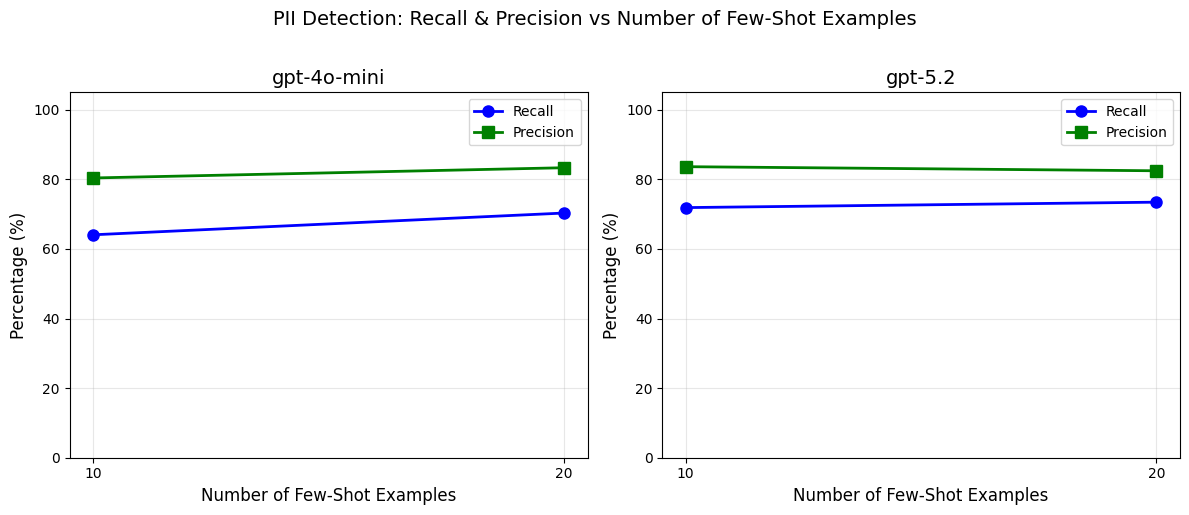

In [76]:
# Configuration for few-shot testing
start_examples = 10  # Starting number of examples
step = 10            # Increase by this many examples each iteration
num_iterations = 2   # Number of iterations (10, 20 examples)

# Run the test
few_shot_results = test_few_shot_with_varying_examples(
    samples, prompt_samples, start_examples, step, num_iterations
)

# Plot the results
plot_few_shot_results(few_shot_results, models_to_test)